# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
experiment_ids = ["11", "13", "14"]
df = utils.MLFlowTaskAPI.mlflow_results_as_dataframe(experiment_ids, run_name="dev-v0.1.2-3-with-replicates")

KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.
KeyError in `mlflow_record_data`.


In [3]:
tasks = []
for i, row in df.iterrows():
    exp: str = row["experiment"]
    ag_neg: str = row["ag_neg"]
    if exp == "11":
        tasks.append("1v1")
    elif exp == "13":
        tasks.append("1v9")
    elif exp == "14":
        if ag_neg.split("_")[1] == "looser":
            tasks.append("high_vs_looser")
        elif ag_neg.split("_")[1] == "95low":
            tasks.append("high_vs_95low")
    else:
        raise ValueError(f"Experiment {exp} not recognized.")
df["task"] = tasks

print(df.columns)
df.head()

Index(['sample_train', 'load_from_miniabsolut_split_seed', 'optimizer_type',
       'ag_neg', 'batch_size', 'epochs', 'num_hidden_units', 'N_closed',
       'N_train', 'split_id', 'ag_pos', 'swa', 'shuffle_antigen_labels',
       'input_dim', 'learning_rate', 'weight_decay', 'momentum', 'seed_id',
       'load_from_miniabsolut', 'acc_closed', 'train_loss', 'roc_auc_closed',
       'f1_closed', 'avg_precision_closed', 'precision_closed', 'test_loss',
       'recall_closed', 'mlflow.source.git.commit', 'mlflow.note.content',
       'mlflow.source.type', 'mlflow.runName', 'mlflow.source.name',
       'mlflow.log-model.history', 'mlflow.user', 'experiment', 'run_id',
       'task'],
      dtype='object')


,sample_train,load_from_miniabsolut_split_seed,optimizer_type,ag_neg,batch_size,epochs,num_hidden_units,N_closed,N_train,split_id,...,mlflow.source.git.commit,mlflow.note.content,mlflow.source.type,mlflow.runName,mlflow.source.name,mlflow.log-model.history,mlflow.user,experiment,run_id,task
0,None,4,Adam,1H0D,64,50,10,10000,30000,0,...,4a705699e06b6c53e8799c26571fc6c360ed4f22,1OB1 vs 1H0D,LOCAL,dev-v0.1.2-3-with-replicates,scripts/script_12a_train_SN10_clean.py,"[{""run_id"": ""45e7f26f9d494b7cb2302f6f13c4bf55""...",eugen,11,45e7f26f9d494b7cb2302f6f13c4bf55,1v1
1,None,4,Adam,3VRL,64,50,10,10000,30000,0,...,4a705699e06b6c53e8799c26571fc6c360ed4f22,1OB1 vs 3VRL,LOCAL,dev-v0.1.2-3-with-replicates,scripts/script_12a_train_SN10_clean.py,"[{""run_id"": ""32f8fd48823c40c5bba365c9243e02de""...",eugen,11,32f8fd48823c40c5bba365c9243e02de,1v1
2,None,4,Adam,1FBI,64,50,10,10000,30000,0,...,4a705699e06b6c53e8799c26571fc6c360ed4f22,1OB1 vs 1FBI,LOCAL,dev-v0.1.2-3-with-replicates,scripts/script_12a_train_SN10_clean.py,"[{""run_id"": ""4f0eb2a80be645e3b6852c649537a693""...",eugen,11,4f0eb2a80be645e3b6852c649537a693,1v1
3,None,4,Adam,1WEJ,64,50,10,10000,30000,0,...,4a705699e06b6c53e8799c26571fc6c360ed4f22,1OB1 vs 1WEJ,LOCAL,dev-v0.1.2-3-with-replicates,scripts/script_12a_train_SN10_clean.py,"[{""run_id"": ""6c6537db1ea246da8ab39ab5b5a8749b""...",eugen,11,6c6537db1ea246da8ab39ab5b5a8749b,1v1
4,None,4,Adam,1NSN,64,50,10,10000,30000,0,...,4a705699e06b6c53e8799c26571fc6c360ed4f22,1OB1 vs 1NSN,LOCAL,dev-v0.1.2-3-with-replicates,scripts/script_12a_train_SN10_clean.py,"[{""run_id"": ""87a555c5f8fb4a92b497369e3113f76b""...",eugen,11,87a555c5f8fb4a92b497369e3113f76b,1v1


In [20]:
df["load_from_miniabsolut_split_seed"].value_counts()

None    600
4       120
3       120
2       120
1       120
0       120
Name: load_from_miniabsolut_split_seed, dtype: int64

In [21]:
df["seed_id"].value_counts()

0    840
3    120
2    120
1    120
Name: seed_id, dtype: int64

## 1A. Performances across tasks
### 1A1 - 1v1 performances

In [4]:
df_11 = df.loc[df["experiment"] == "11"].copy()
df_11["ags_sorted"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: "_".join(sorted(x)), axis=1)
df_11["ag_1"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: sorted(x)[0], axis=1)
df_11["ag_2"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: sorted(x)[1], axis=1)

Difference between (+,-) and (-,+). Generally below 0.3%. 2 cases of 0.5%. Can be ignored. Difference is of the same order as replicates. Sorting the performance by ag_pos or ag_neg leads to the same order (not shown now).

<AxesSubplot: ylabel='Frequency'>

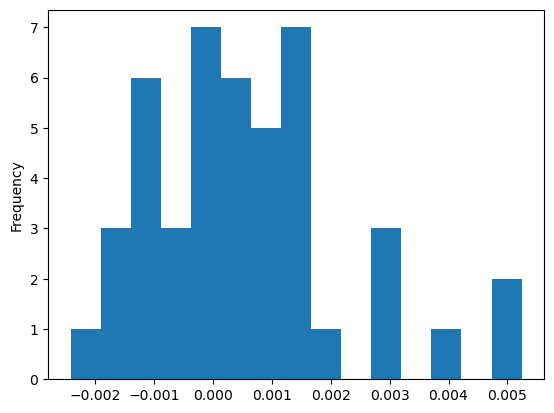

In [5]:
records = []
for ags_sorted in df_11.ags_sorted.unique():
    ag_1 = ags_sorted.split("_")[0]
    ag_2 = ags_sorted.split("_")[1]

    mask_p = (df_11["ag_pos"] == ag_1) & (df_11["ag_neg"] == ag_2)
    mask_n = (df_11["ag_pos"] == ag_2) & (df_11["ag_neg"] == ag_1)

    p_avg = df_11.loc[mask_p]["acc_closed"].mean()
    # p_std = df_11.loc[mask_p]["acc_closed"].std()
    n_avg = df_11.loc[mask_n]["acc_closed"].mean()
    # n_std = df_11.loc[mask_n]["acc_closed"].std()

    records.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "ags_sorted": ags_sorted,
        "p_avg": p_avg,
        "n_avg": n_avg,
        "diff": p_avg - n_avg,
    })

df_11_diff = pd.DataFrame(records)
df_11_diff["diff"].plot.hist(bins=15)

When aggregating by ags_sorted, we get low stds (~0.5% is max, but most are around 0.1%), so that, differences of >1% are significant.

In [6]:
df_11.groupby("ags_sorted")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ags_sorted,,
1FBI_3VRL,0.994135,0.000758
1H0D_1OB1,0.992825,0.000648
1FBI_1NSN,0.992070,0.001312
1FBI_1H0D,0.990965,0.002083
1NSN_3VRL,0.990545,0.000798
1FBI_1OB1,0.990495,0.000709
1H0D_3VRL,0.990195,0.000965
2YPV_3VRL,0.989785,0.001281
1OB1_3VRL,0.987055,0.001286


<AxesSubplot: xlabel='ag_pos', ylabel='acc_closed'>

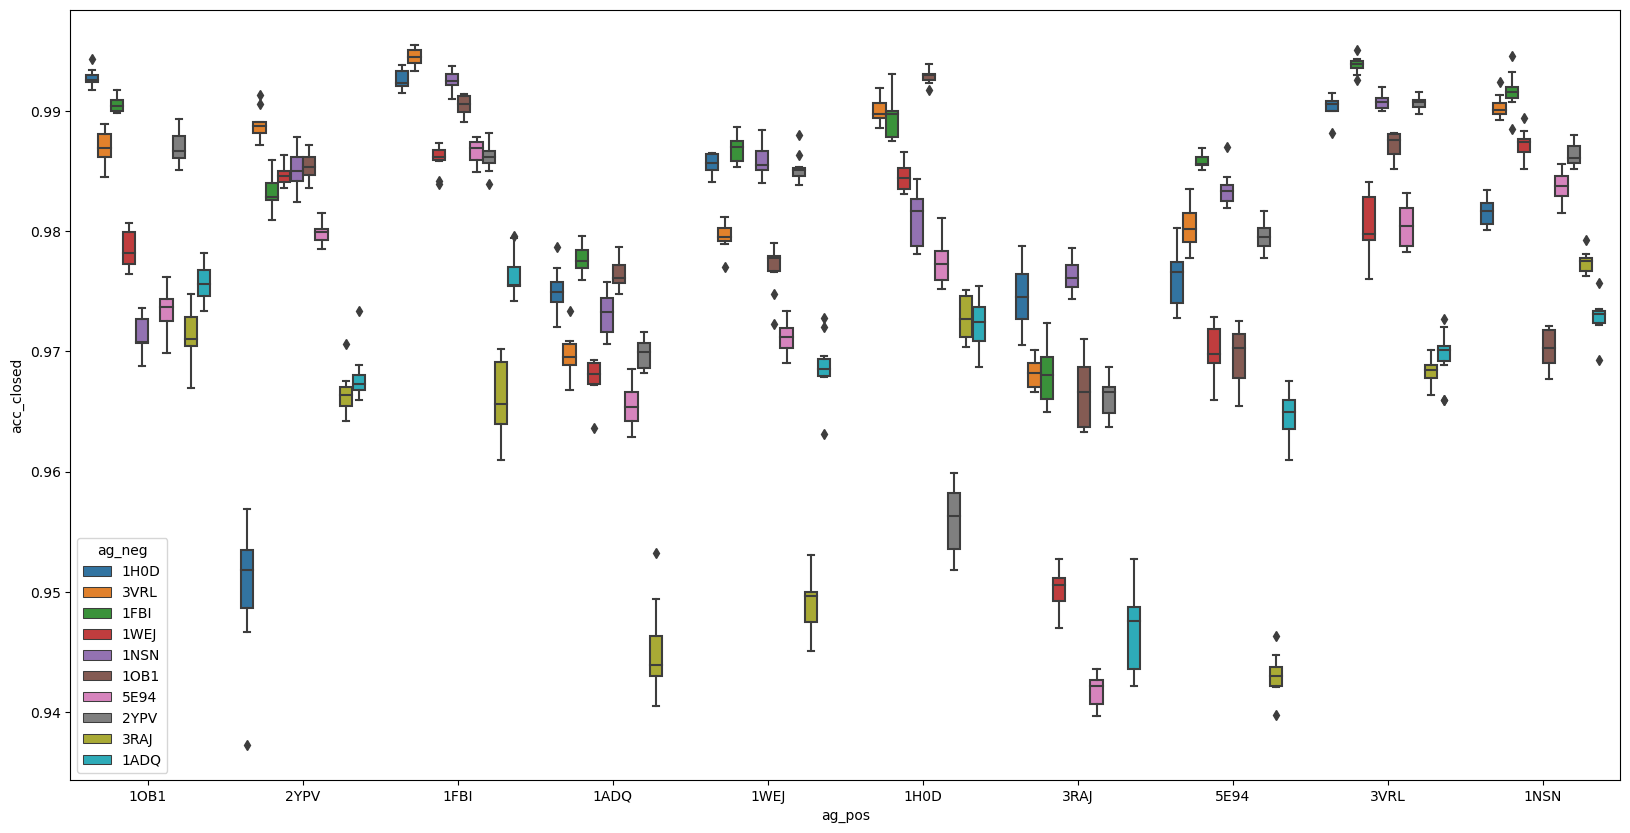

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="ag_neg",
    data=df_11,
    ax=ax,
)

<AxesSubplot: xlabel='(acc_closed, mean)', ylabel='(acc_closed, std)'>

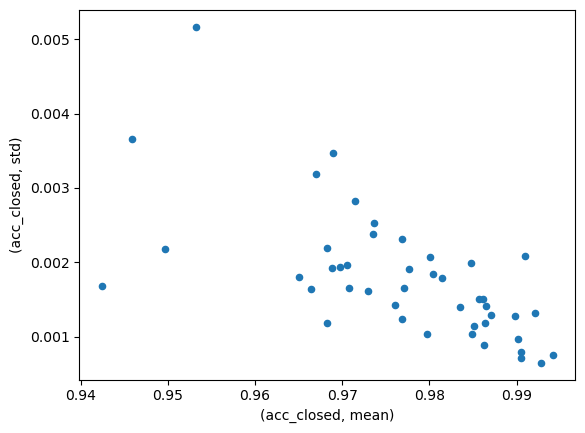

In [8]:
df_11.groupby(["ag_1", "ag_2"]).agg({"acc_closed": ["mean", "std"]}).plot(
    x=("acc_closed", "mean"),
    y=("acc_closed", "std"),
    kind="scatter",
)

In [9]:
df_11_g = df_11.groupby(["ag_1", "ag_2"]).agg("mean")["acc_closed"]

df_11_m = pd.DataFrame(np.zeros((10, 10)), columns=df_11.ag_pos.unique(), index=df_11.ag_pos.unique())
for ag_pos in df_11.ag_pos.unique():
    for ag_neg in df_11.ag_neg.unique():
        if ag_pos == ag_neg:
            continue
        else:
            ag_1 = sorted([ag_pos, ag_neg])[0]
            ag_2 = sorted([ag_pos, ag_neg])[1]
            df_11_m.loc[ag_pos, ag_neg] = df_11_g[ag_1][ag_2]
            df_11_m.loc[ag_neg, ag_pos] = df_11_g[ag_1][ag_2]

/tmp/ipykernel_2485981/1146087541.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_11_g = df_11.groupby(["ag_1", "ag_2"]).agg("mean")["acc_closed"]


<AxesSubplot: >

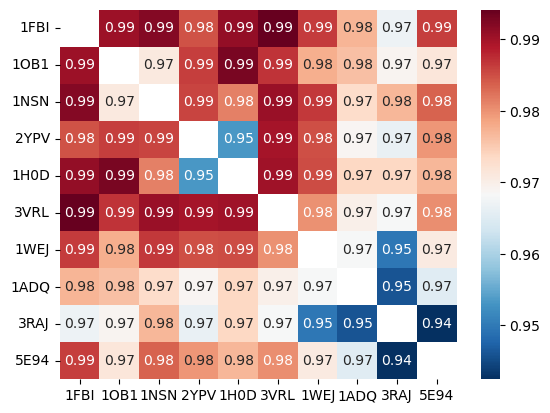

In [10]:
# sns.clustermap(df_11_m, annot=True, cmap="RdBu_r", mask=df_11_m==0)
# g = sns.clustermap(df_11_m, annot=True, cmap="RdBu_r", mask=np.tri(df_11_m.values.shape[0], k=0))

## Doesn't achieve clustermap with mask.
# https://stackoverflow.com/questions/67879908/lower-triangle-mask-with-seaborn-clustermap
# mask = np.tril(np.ones_like(df_11_m))
# values = g.ax_heatmap.collections[0].get_array().reshape(df_11_m.shape)
# new_values = np.ma.array(values, mask=mask)
# g.ax_heatmap.collections[0].set_array(new_values)
# plt.show()

## To get a clustermap with masks, I hardcode the order from the clustermap.
order = ["5E94", "3RAJ", "1ADQ", "1WEJ", "3VRL", "1H0D", "2YPV", "1NSN", "1OB1", "1FBI"]
df_11_m = df_11_m.loc[order[::-1], order[::-1]]
# sns.heatmap(df_11_m, annot=True, cmap="RdBu_r", mask=np.tri(df_11_m.values.shape[0], k=0))
sns.heatmap(df_11_m, annot=True, cmap="RdBu_r", mask=df_11_m.values == 0)

High standard deviations when considering all combinations containing an antigen (stds ~ 1%), but statistically significant differences.

In [11]:
# Statistical test
from itertools import combinations
from scipy.stats import ttest_ind
records = []
for ag_i, ag_j in combinations(df_11.ag_pos.unique(), 2):
    if ag_i == ag_j:
        continue
    mask_i = (df_11["ag_1"] == ag_i) | (df_11["ag_2"] == ag_i)
    mask_j = (df_11["ag_1"] == ag_j) | (df_11["ag_2"] == ag_j)
    t, p = ttest_ind(df_11.loc[mask_i]["acc_closed"], df_11.loc[mask_j]["acc_closed"])
    records.append({
        "ag_i": ag_i,
        "ag_j": ag_j,
        "t": t,
        "p": p,
    })
df_11_stats = pd.DataFrame(records).sort_values("p", ascending=True)
print(df_11_stats.head(10))
print(df_11_stats.tail(10))

# Tabular
records = []
for ag in df_11.ag_pos.unique():
    mask = (df_11["ag_1"] == ag) | (df_11["ag_2"] == ag)
    acc_avg = df_11.loc[mask]["acc_closed"].mean()
    acc_std = df_11.loc[mask]["acc_closed"].std()
    records.append({
        "ag": ag,
        "acc": acc_avg,
        "acc_std": acc_std,
        "acc_range": f'{df_11.loc[mask]["acc_closed"].min()} - {df_11.loc[mask]["acc_closed"].max()}',
        "acc_range_est": f"{acc_avg - 2*acc_std:.3f} - {min(acc_avg + 2*acc_std, 1.0):.3f}",
    })
pd.DataFrame(records).sort_values("acc", ascending=False)

    ag_i  ag_j          t             p
20  1FBI  3RAJ  21.230891  2.494091e-65
41  3RAJ  1NSN -19.101725  1.395175e-56
40  3RAJ  3VRL -18.791898  2.636827e-55
17  1FBI  1ADQ  18.384364  1.258865e-53
5   1OB1  3RAJ  16.075014  3.721395e-44
29  1ADQ  1NSN -15.833300  3.575447e-43
28  1ADQ  3VRL -15.469618  1.064015e-41
35  1H0D  3RAJ  13.855159  2.992645e-35
13  2YPV  3RAJ  12.353083  1.918557e-29
2   1OB1  1ADQ  12.235183  5.351503e-29
    ag_i  ag_j         t         p
32  1WEJ  5E94  2.851231  0.004608
30  1WEJ  1H0D -2.556987  0.010970
8   1OB1  1NSN -2.510576  0.012494
38  1H0D  1NSN -2.438776  0.015222
22  1FBI  3VRL  2.317428  0.021044
0   1OB1  2YPV  2.231070  0.026295
12  2YPV  1H0D -1.630893  0.103792
44  3VRL  1NSN  1.244406  0.214164
11  2YPV  1WEJ  0.924887  0.355648
4   1OB1  1H0D  0.366876  0.713928


,ag,acc,acc_std,acc_range,acc_range_est
2,1FBI,0.985455,0.008272,0.961 - 0.9955,0.969 - 1.000
8,3VRL,0.983346,0.008980,0.966 - 0.9955,0.965 - 1.000
9,1NSN,0.982280,0.007175,0.9677 - 0.9946,0.968 - 0.997
0,1OB1,0.980154,0.008806,0.9633 - 0.9943,0.963 - 0.998
5,1H0D,0.979749,0.011934,0.9373 - 0.9943,0.956 - 1.000
1,2YPV,0.977714,0.011741,0.9373 - 0.9916,0.954 - 1.000
4,1WEJ,0.976576,0.011611,0.9451 - 0.9894,0.953 - 1.000
7,5E94,0.972924,0.012662,0.9397 - 0.9878,0.948 - 0.998
3,1ADQ,0.968611,0.009092,0.9405 - 0.9796,0.950 - 0.987
6,3RAJ,0.962118,0.012209,0.9397 - 0.9793,0.938 - 0.987


### 1A2 - looser, 95low and 1v9 performances.

In [12]:
import warnings


# Include 1v1 average performance
warnings.warn("This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.")

df_13 = df.loc[df["experiment"].isin(["11", "13", "14"])].copy()
df_13["ag_pos"] = df_13["ag_pos"].apply(lambda x: x.split("_")[0])

# Get order of antigens by high_vs_looser performance
ag_order = df_13.loc[df_13["task"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

/tmp/ipykernel_2485981/1123551908.py:5: UserWarning: This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.
  warnings.warn("This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.")


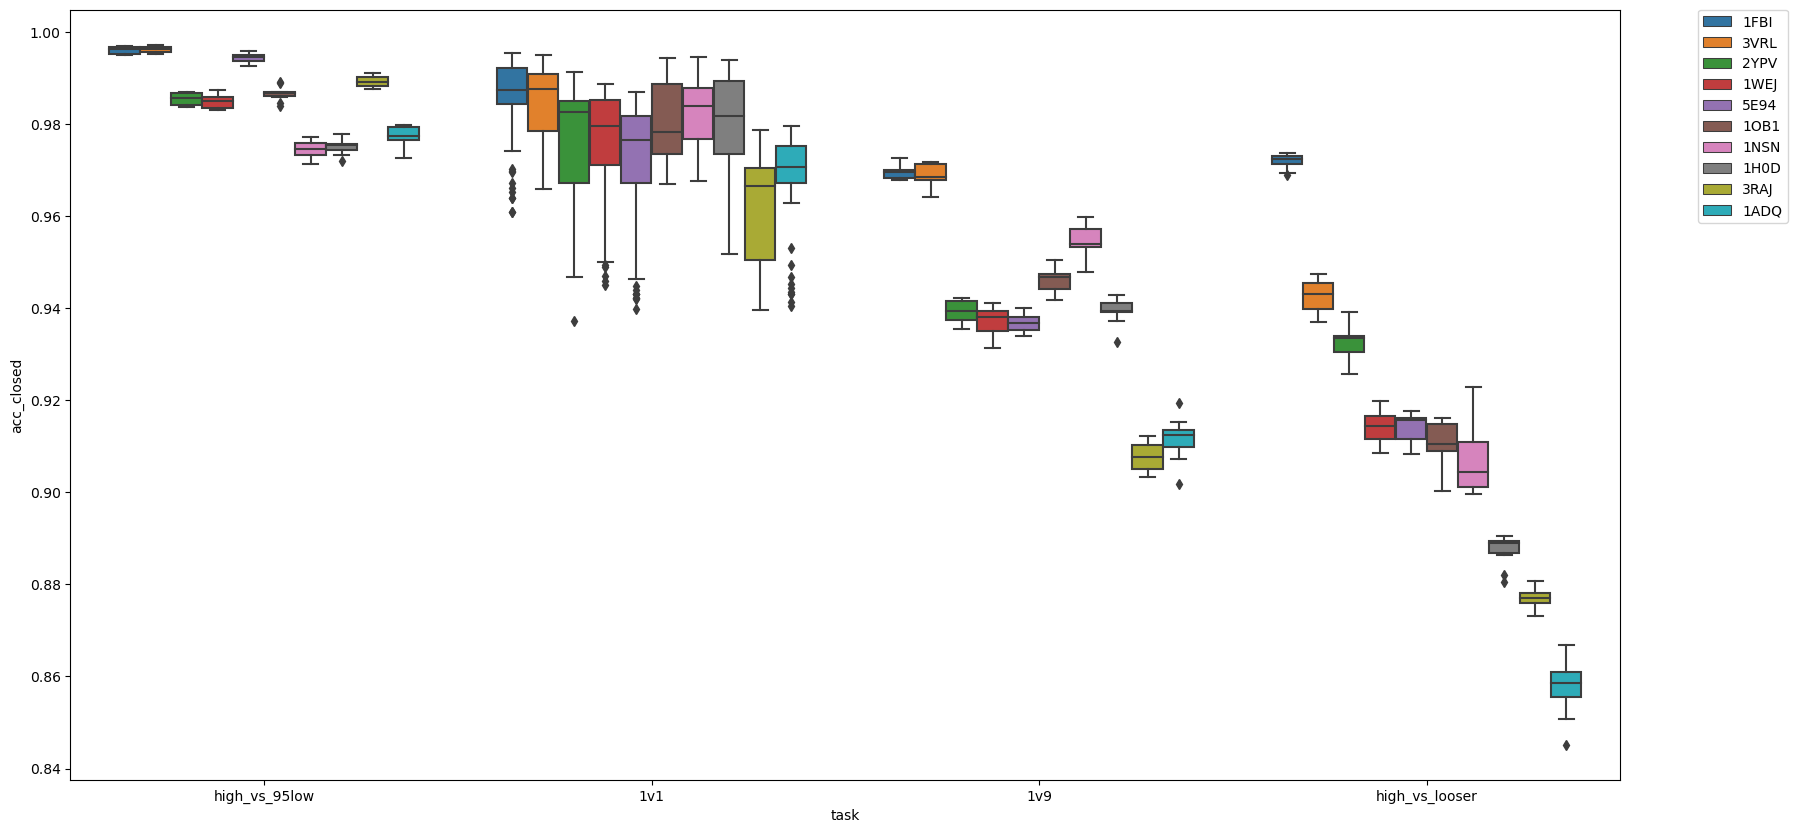

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(
    x="task",
    y="acc_closed",
    hue="ag_pos",
    data=df_13,
    ax=ax,
    # Order on x axis
    order=["high_vs_95low", "1v1", "1v9", "high_vs_looser"],
    hue_order=ag_order,
)

# Legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

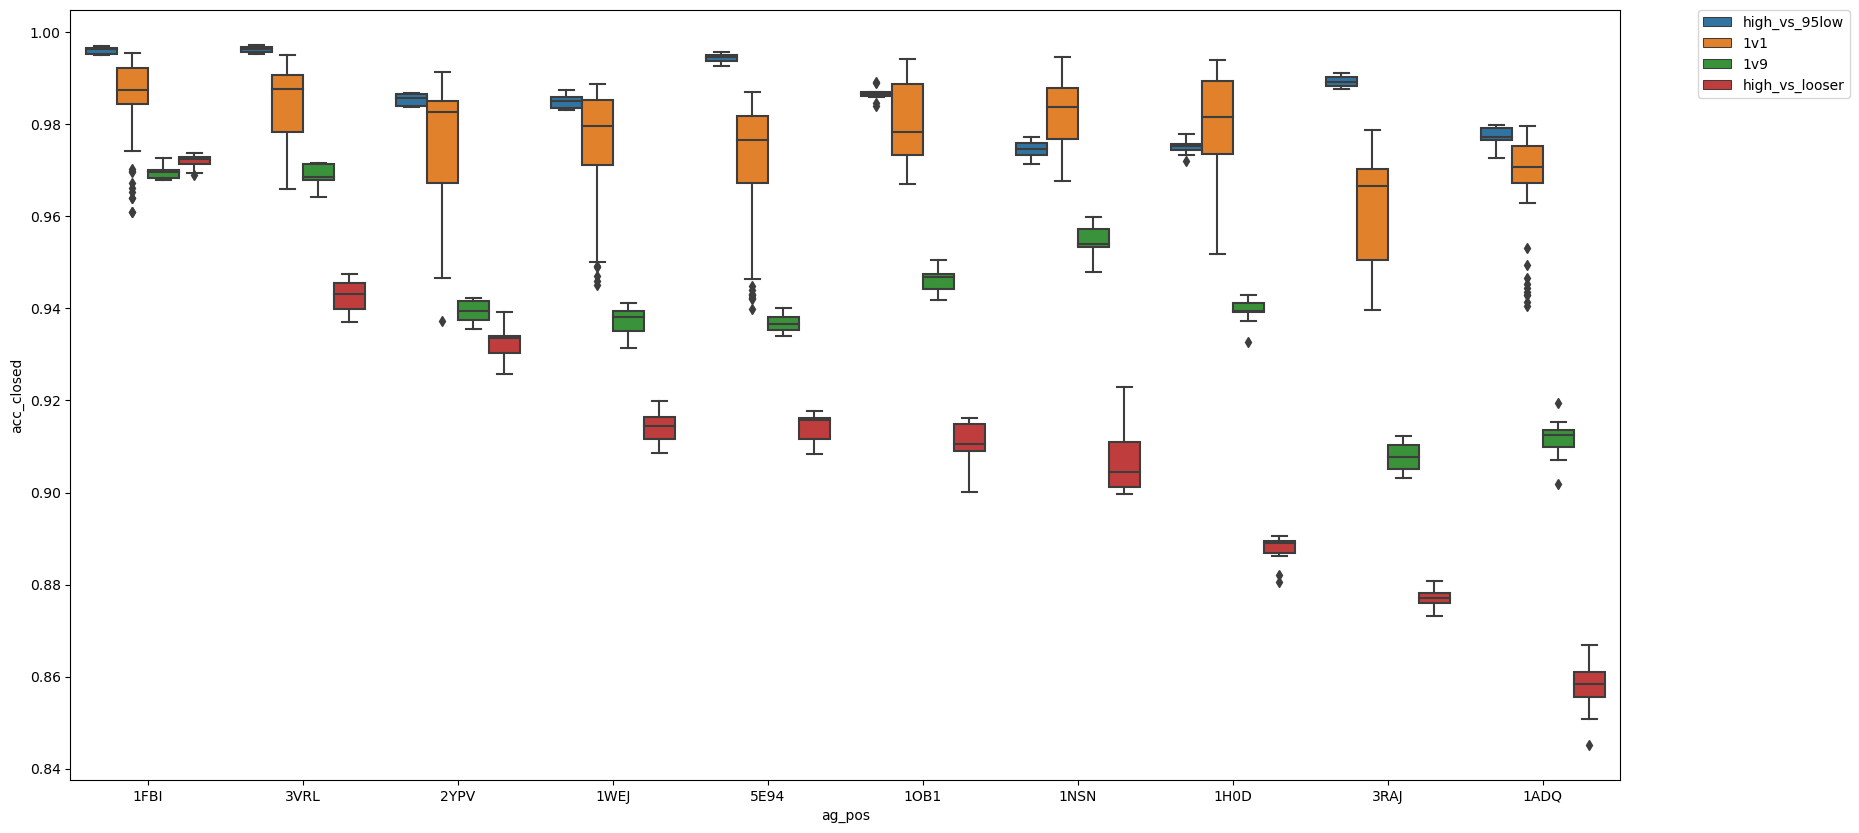

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task",
    data=df_13,
    ax=ax,
    order=ag_order,
    hue_order=["high_vs_95low", "1v1", "1v9", "high_vs_looser"],
    
)

# Legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
@np.vectorize
def get_ag_order_index(ag, ag_order=ag_order):
    return ag_order.index(ag)

df_13 = df_13.sort_values(["ag_pos"], key=get_ag_order_index)

<AxesSubplot: xlabel='ag_pos', ylabel='acc_closed'>

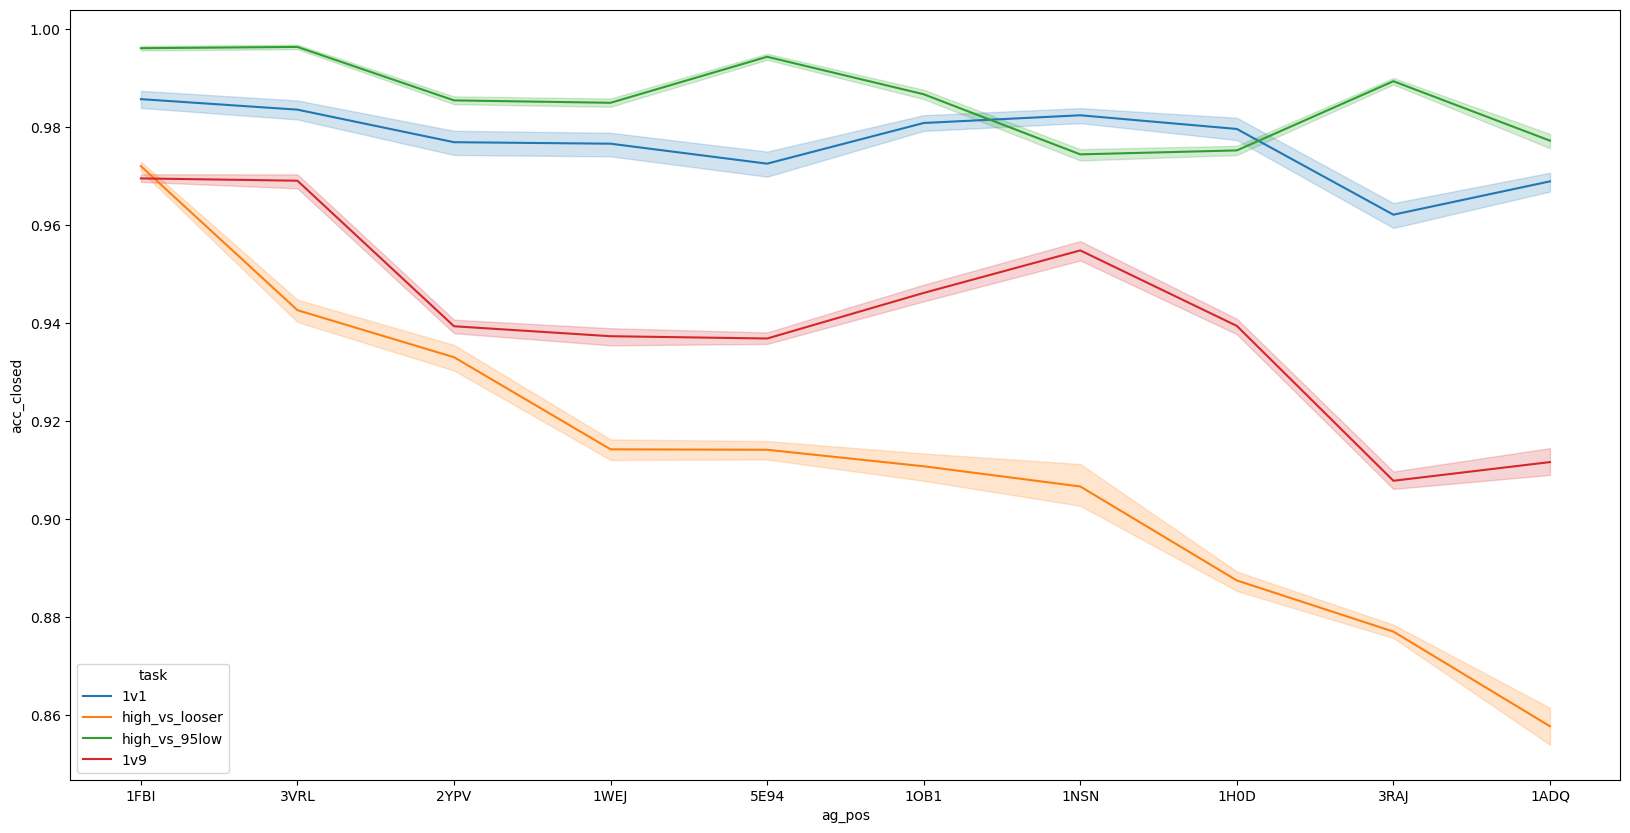

In [16]:
# Seaborn lineplot, x-axis is categorical
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    x="ag_pos",
    y="acc_closed",
    hue="task",
    data=df_13,
    ax=ax,
)

## 2. Similarity between antigens